# Importing Libraries

In [1]:
import os
import pickle
import pandas as pd
import numpy as np

# Processing the Data

In [2]:
data_path = 'WESAD/WESAD'
subjects = [f for f in os.listdir(data_path) if f.startswith('S')]
data_frames = []

for subject in subjects:
    subject_path = os.path.join(data_path, subject, f'{subject}.pkl')
    with open(subject_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')

    chest_data = data['signal']['chest']
    wrist_data = data['signal']['wrist']
    stress = data['label']

    chest_sensor_dfs = []
    for sensor_name, sensor_values in chest_data.items():
        sensor_array = np.array(sensor_values)
        if sensor_array.ndim == 1:
            sensor_array = sensor_array.reshape(-1, 1)
        num_axes = sensor_array.shape[1]
        col_names = [f'chest_{sensor_name}_{i}' for i in range(num_axes)]
        chest_sensor_df = pd.DataFrame(sensor_array, columns=col_names)
        chest_sensor_dfs.append(chest_sensor_df)
    chest_df = pd.concat(chest_sensor_dfs, axis=1)

    wrist_sensor_dfs = []
    for sensor_name, sensor_values in wrist_data.items():
        sensor_array = np.array(sensor_values)
        if sensor_array.ndim == 1:
            sensor_array = sensor_array.reshape(-1, 1)
        num_axes = sensor_array.shape[1]
        col_names = [f'wrist_{sensor_name}_{i}' for i in range(num_axes)]
        wrist_sensor_df = pd.DataFrame(sensor_array, columns=col_names)
        wrist_sensor_dfs.append(wrist_sensor_df)
    wrist_df = pd.concat(wrist_sensor_dfs, axis=1)

    subject_df = pd.concat([chest_df, wrist_df], axis=1)
    subject_df['stress'] = stress
    subject_df['subject'] = subject
    subject_df = subject_df.head(10000)
    data_frames.append(subject_df)

data_df = pd.concat(data_frames, ignore_index=True)
data_df.to_csv('data.csv', index=False)

# Data Pre-processing

In [3]:
df = pd.read_csv('data.csv')

In [4]:
print(f"Rows: {data_df.shape[0]}, Columns: {data_df.shape[1]}")

Rows: 30000, Columns: 16


In [5]:
df.drop(columns=['stress'], inplace=True)

In [6]:
print(df.isnull().sum())

chest_ACC_0     0
chest_ACC_1     0
chest_ACC_2     0
chest_ECG_0     0
chest_EMG_0     0
chest_EDA_0     0
chest_Temp_0    0
chest_Resp_0    0
wrist_ACC_0     0
wrist_ACC_1     0
wrist_ACC_2     0
wrist_BVP_0     0
wrist_EDA_0     0
wrist_TEMP_0    0
subject         0
dtype: int64


In [7]:
df.head()

,chest_ACC_0,chest_ACC_1,chest_ACC_2,chest_ECG_0,chest_EMG_0,chest_EDA_0,chest_Temp_0,chest_Resp_0,wrist_ACC_0,wrist_ACC_1,wrist_ACC_2,wrist_BVP_0,wrist_EDA_0,wrist_TEMP_0,subject
0,0.9554,-0.2220,-0.5580,0.021423,-0.004440,5.250549,30.120758,-1.148987,62.0,-21.0,107.0,-59.37,1.138257,35.41,S2
1,0.9258,-0.2216,-0.5538,0.020325,0.004349,5.267334,30.129517,-1.124573,66.0,13.0,53.0,-53.42,1.125444,35.41,S2
2,0.9082,-0.2196,-0.5392,0.016525,0.005173,5.243301,30.138214,-1.152039,41.0,9.0,15.0,-44.40,1.011405,35.41,S2
3,0.8974,-0.2102,-0.5122,0.016708,0.007187,5.249405,30.129517,-1.158142,52.0,16.0,24.0,-33.17,1.033188,35.41,S2
4,0.8882,-0.2036,-0.4824,0.011673,-0.015152,5.286407,30.130950,-1.161194,54.0,15.0,34.0,-20.79,0.935807,35.41,S2


###### Variables:

chest_ACC_0 / chest_ACC_1 / chest_ACC_2 – 3-axis accelerometer readings from the chest sensor, measuring physical movement or activity levels along X, Y, and Z axes.


chest_ECG_0 – Raw electrocardiogram (ECG) signal from the chest, capturing electrical activity of the heart.


chest_EMG_0 – Electromyogram (EMG) signal from the chest, reflecting muscle activity and tension.


chest_EDA_0 – Electrodermal activity (EDA) from the chest, indicating changes in skin conductance often associated with stress or arousal.


chest_Temp_0 – Skin temperature recorded at the chest, which can vary with stress or physical exertion.


chest_Resp_0 – Respiratory signal from the chest, measuring breathing patterns.


wrist_ACC_0 / wrist_ACC_1 / wrist_ACC_2 – 3-axis accelerometer readings from the wrist sensor, detecting wrist movement in X, Y, and Z directions.


wrist_BVP_0 – Blood volume pulse (BVP) signal from the wrist, used to derive heart rate and variability.


wrist_EDA_0 – Electrodermal activity from the wrist, another measure of skin conductance linked to emotional arousal.


wrist_TEMP_0 – Skin temperature measured at the wrist.


subject – Identifier for the participant from whom the data was collected.

#### Target Variable

Blood Volume Pulse (BVP) values do influence stress levels directly. BVP, measured using photoplethysmography (PPG), reflects cardiovascular changes related to stress responses. Studies have shown that BVP signals, along with other physiological indicators like Electrodermal Activity (EDA) and heart rate, can effectively detect and classify stress levels. For instance, research utilizing wrist-worn PPG sensors has demonstrated that BVP, in combination with EDA, achieves high accuracy in stress detection.

I can use wrist_BVP_0 as my target variable because it reflects continuous cardiovascular activity, which is influenced by stress and affective states. Predicting BVP from other biometric signals allows me to model physiological responses and explore sensor fusion, making it a meaningful and valid regression problem for my project.

In [8]:
df.wrist_BVP_0.describe()

count    30000.000000
mean         0.014584
std         50.229612
min       -477.350000
25%        -19.720000
50%          2.800000
75%         20.690000
max        462.670000
Name: wrist_BVP_0, dtype: float64

In [9]:
df.rename(columns={'wrist_BVP_0': 'BVP'}, inplace=True)
df['BVP'] = df['BVP'].abs()

In [10]:
df.head()

,chest_ACC_0,chest_ACC_1,chest_ACC_2,chest_ECG_0,chest_EMG_0,chest_EDA_0,chest_Temp_0,chest_Resp_0,wrist_ACC_0,wrist_ACC_1,wrist_ACC_2,BVP,wrist_EDA_0,wrist_TEMP_0,subject
0,0.9554,-0.2220,-0.5580,0.021423,-0.004440,5.250549,30.120758,-1.148987,62.0,-21.0,107.0,59.37,1.138257,35.41,S2
1,0.9258,-0.2216,-0.5538,0.020325,0.004349,5.267334,30.129517,-1.124573,66.0,13.0,53.0,53.42,1.125444,35.41,S2
2,0.9082,-0.2196,-0.5392,0.016525,0.005173,5.243301,30.138214,-1.152039,41.0,9.0,15.0,44.40,1.011405,35.41,S2
3,0.8974,-0.2102,-0.5122,0.016708,0.007187,5.249405,30.129517,-1.158142,52.0,16.0,24.0,33.17,1.033188,35.41,S2
4,0.8882,-0.2036,-0.4824,0.011673,-0.015152,5.286407,30.130950,-1.161194,54.0,15.0,34.0,20.79,0.935807,35.41,S2


In [11]:
df.BVP.describe()

count    30000.000000
mean        31.392361
std         39.210979
min          0.000000
25%          9.157500
50%         20.270000
75%         36.670000
max        477.350000
Name: BVP, dtype: float64

# Visualization of Data

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

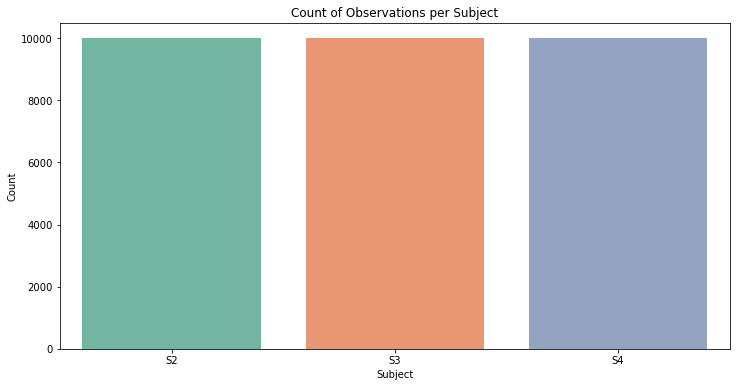

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(x='subject', data=df, palette='Set2')
plt.title('Count of Observations per Subject')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.show()

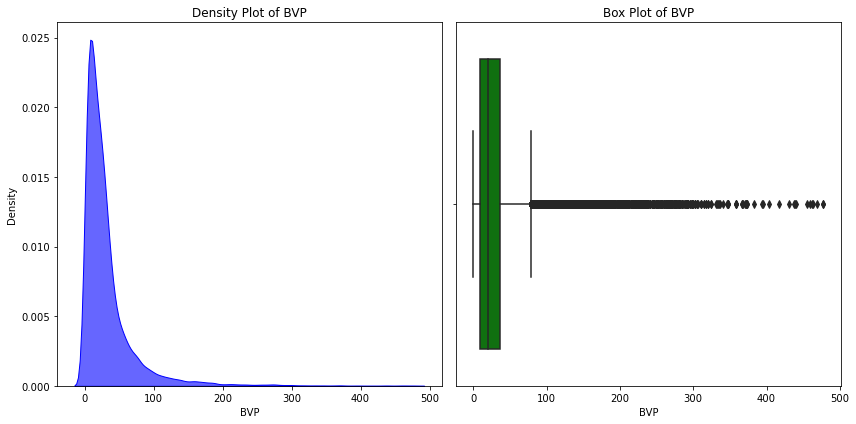

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.kdeplot(df['BVP'], fill=True, color='blue', alpha=0.6, ax=axes[0])
axes[0].set_title('Density Plot of BVP')
axes[0].set_xlabel('BVP')
axes[0].set_ylabel('Density')
sns.boxplot(x=df['BVP'], color='green', ax=axes[1])
axes[1].set_title('Box Plot of BVP')
axes[1].set_xlabel('BVP')
plt.tight_layout()
plt.show()

In [16]:
Q1 = df['BVP'].quantile(0.25)
Q3 = df['BVP'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['BVP'] >= lower_bound) & (df['BVP'] <= upper_bound)]

<Figure size 864x432 with 0 Axes>

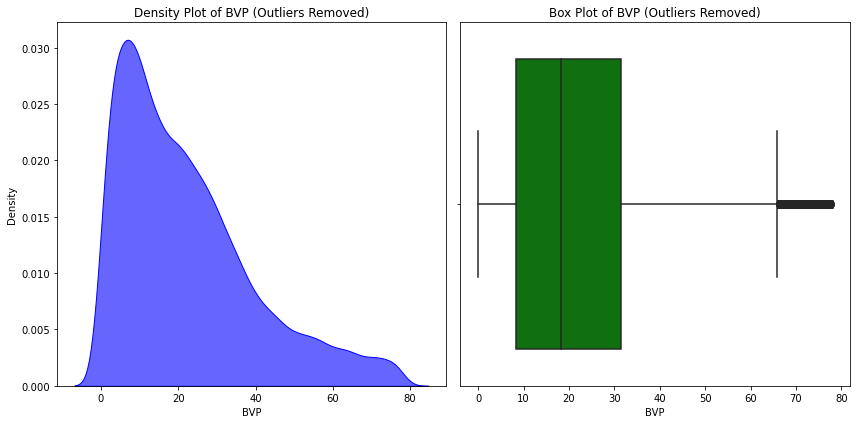

In [17]:
plt.figure(figsize=(12, 6))
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.kdeplot(df['BVP'], fill=True, color='blue', alpha=0.6, ax=axes[0])
axes[0].set_title('Density Plot of BVP (Outliers Removed)')
axes[0].set_xlabel('BVP')
axes[0].set_ylabel('Density')
sns.boxplot(x=df['BVP'], color='green', ax=axes[1])
axes[1].set_title('Box Plot of BVP (Outliers Removed)')
axes[1].set_xlabel('BVP')
plt.tight_layout()
plt.show()

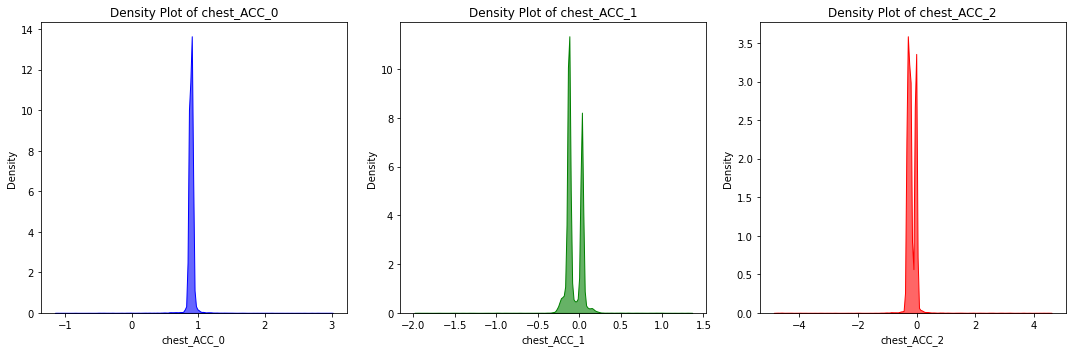

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(df['chest_ACC_0'], fill=True, color='blue', alpha=0.6, ax=axes[0])
axes[0].set_title('Density Plot of chest_ACC_0')
axes[0].set_xlabel('chest_ACC_0')
axes[0].set_ylabel('Density')
sns.kdeplot(df['chest_ACC_1'], fill=True, color='green', alpha=0.6, ax=axes[1])
axes[1].set_title('Density Plot of chest_ACC_1')
axes[1].set_xlabel('chest_ACC_1')
axes[1].set_ylabel('Density')
sns.kdeplot(df['chest_ACC_2'], fill=True, color='red', alpha=0.6, ax=axes[2])
axes[2].set_title('Density Plot of chest_ACC_2')
axes[2].set_xlabel('chest_ACC_2')
axes[2].set_ylabel('Density')
plt.tight_layout()
plt.show()

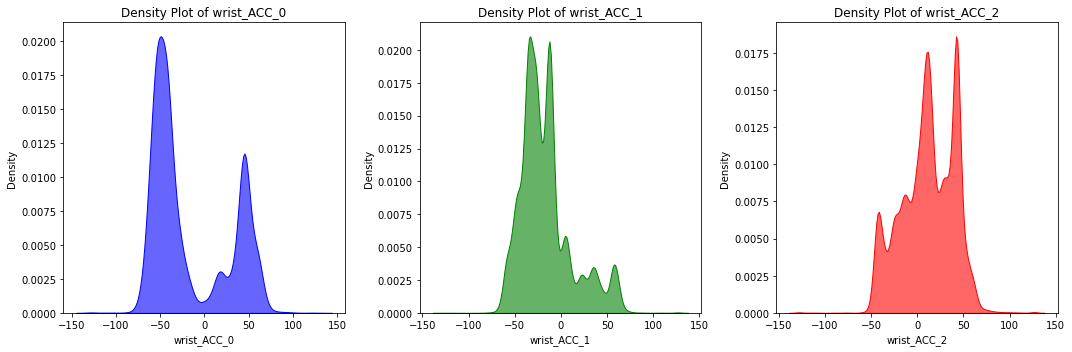

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(df['wrist_ACC_0'], fill=True, color='blue', alpha=0.6, ax=axes[0])
axes[0].set_title('Density Plot of wrist_ACC_0')
axes[0].set_xlabel('wrist_ACC_0')
axes[0].set_ylabel('Density')
sns.kdeplot(df['wrist_ACC_1'], fill=True, color='green', alpha=0.6, ax=axes[1])
axes[1].set_title('Density Plot of wrist_ACC_1')
axes[1].set_xlabel('wrist_ACC_1')
axes[1].set_ylabel('Density')
sns.kdeplot(df['wrist_ACC_2'], fill=True, color='red', alpha=0.6, ax=axes[2])
axes[2].set_title('Density Plot of wrist_ACC_2')
axes[2].set_xlabel('wrist_ACC_2')
axes[2].set_ylabel('Density')
plt.tight_layout()
plt.show()

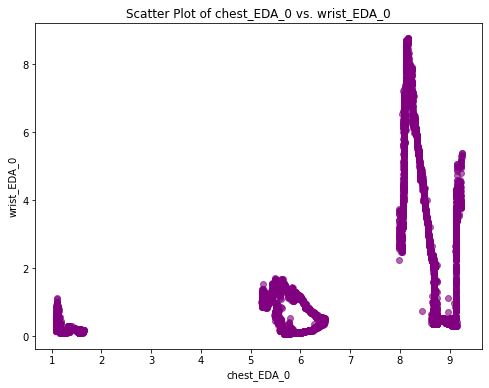

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(df['chest_EDA_0'], df['wrist_EDA_0'], alpha=0.6, color='purple')
plt.title('Scatter Plot of chest_EDA_0 vs. wrist_EDA_0')
plt.xlabel('chest_EDA_0')
plt.ylabel('wrist_EDA_0')
plt.show()

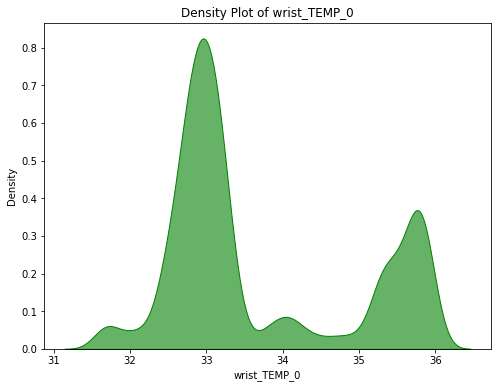

In [21]:
plt.figure(figsize=(8, 6))
sns.kdeplot(df['wrist_TEMP_0'], fill=True, color='green', alpha=0.6)
plt.title('Density Plot of wrist_TEMP_0')
plt.xlabel('wrist_TEMP_0')
plt.ylabel('Density')
plt.show()

# Data Modeling

In [22]:
df.drop(columns=['subject'], inplace=True)

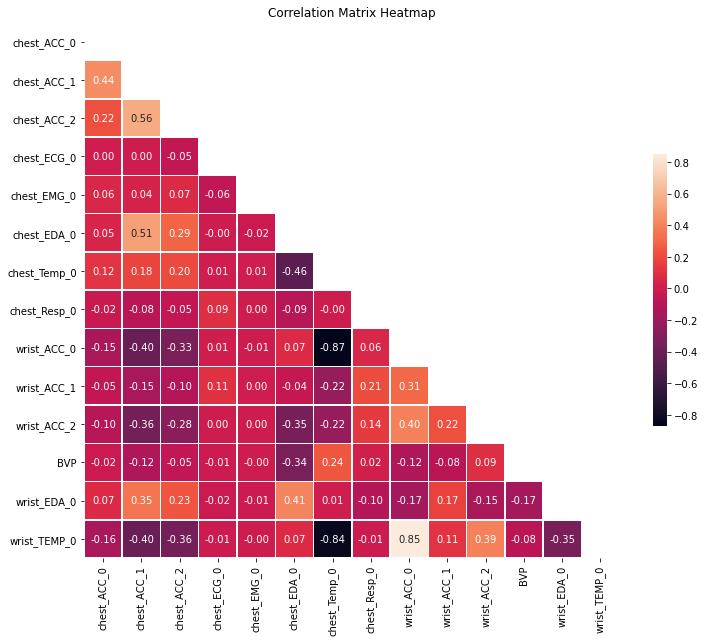

In [24]:
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix Heatmap')
plt.show()

In [25]:
from sklearn.preprocessing import StandardScaler

In [27]:
y = df['BVP']; x = df.drop(columns=['BVP'])

scaler = StandardScaler()
x = scaler.fit_transform(x)

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [30]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (22062, 13)
x_test shape: (5516, 13)


## Regression Modelling

### 1. Linear Regression: Baseline

# Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [32]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_train)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print("Train Mean Squared Error (MSE):", mse)
print("Train R-squared (R2):", r2)

Train Mean Squared Error (MSE): 268.88594131621085
Train R-squared (R2): 0.1310050944178508


In [33]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test Mean Squared Error (MSE):", mse)
print("Test R-squared (R2):", r2)

Test Mean Squared Error (MSE): 266.90653174487187
Test R-squared (R2): 0.12581745081017082


In [35]:
lr_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
lr_results.head(10)

,Actual,Predicted
29953,25.81,31.815821
14841,1.52,17.162013
21218,6.34,32.359024
7898,33.08,19.175119
7255,0.35,18.643244
533,48.74,22.186488
6462,22.73,20.542695
22017,52.65,32.400830
6302,0.20,19.836096
29403,56.03,30.447159


### 2. Lasso Regression

# Lasso Regression

In [36]:
from sklearn.linear_model import Lasso

In [37]:
model = Lasso()
model.fit(x_train, y_train)
y_pred = model.predict(x_train)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print("Train Mean Squared Error (MSE):", mse)
print("Train R-squared (R2):", r2)

Train Mean Squared Error (MSE): 271.94346611435293
Train R-squared (R2): 0.12112367979174377


In [38]:
model = Lasso()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test Mean Squared Error (MSE):", mse)
print("Test R-squared (R2):", r2)

Test Mean Squared Error (MSE): 270.034188460318
Test R-squared (R2): 0.11557362911489344


In [39]:
lsr_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
lsr_results.head(10)

,Actual,Predicted
29953,25.81,29.447431
14841,1.52,17.464821
21218,6.34,30.065990
7898,33.08,20.814260
7255,0.35,20.028852
533,48.74,21.629857
6462,22.73,20.594433
22017,52.65,30.020044
6302,0.20,20.462743
29403,56.03,28.992938


### 3. Random Forest Regression

# Random Forest Regression

In [40]:
from sklearn.ensemble import RandomForestRegressor

In [41]:
model = RandomForestRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_train)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print("Train Mean Squared Error (MSE):", mse)
print("Train R-squared (R2):", r2)

Train Mean Squared Error (MSE): 14.414837310607833
Train R-squared (R2): 0.9534136291157648


In [42]:
model = RandomForestRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test Mean Squared Error (MSE):", mse)
print("Test R-squared (R2):", r2)

Test Mean Squared Error (MSE): 103.54977982277556
Test R-squared (R2): 0.6608497742571312


In [43]:
rfr_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
rfr_results.head(10)

,Actual,Predicted
29953,25.81,26.5678
14841,1.52,5.6239
21218,6.34,28.9789
7898,33.08,24.6833
7255,0.35,4.3613
533,48.74,31.1317
6462,22.73,23.1879
22017,52.65,63.6477
6302,0.20,10.2112
29403,56.03,53.7831


### 4. XGBoost Regression

# XGBoost Regression

In [45]:
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

In [46]:
model = XGBRegressor(objective='reg:squarederror')
model.fit(x_train, y_train)
y_pred = model.predict(x_train)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print("Train Mean Squared Error (MSE):", mse)
print("Train R-squared (R2):", r2)

Train Mean Squared Error (MSE): 91.8802314080259
Train R-squared (R2): 0.7030582832763752


In [47]:
model = XGBRegressor(objective='reg:squarederror')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test Mean Squared Error (MSE):", mse)
print("Test R-squared (R2):", r2)

Test Mean Squared Error (MSE): 159.32531260674565
Test R-squared (R2): 0.478171601816907


In [48]:
xgb_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
xgb_results.head(10)

,Actual,Predicted
29953,25.81,20.446409
14841,1.52,8.866219
21218,6.34,25.502895
7898,33.08,28.857565
7255,0.35,4.712342
533,48.74,35.522808
6462,22.73,18.933292
22017,52.65,50.323387
6302,0.20,12.717027
29403,56.03,43.486526


## Results

# Results

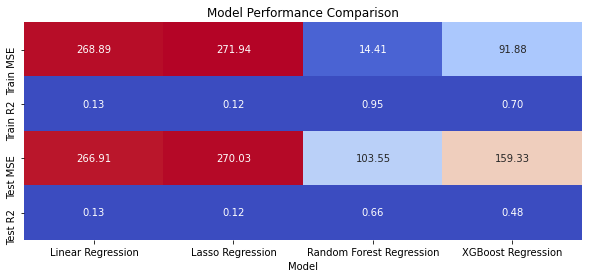

In [49]:
results = {'Model': ['Linear Regression', 'Lasso Regression', 'Random Forest Regression', 'XGBoost Regression'],
           'Train MSE': [268.89, 271.94, 14.41, 91.88],
           'Train R2': [0.131, 0.121, 0.953, 0.703],
           'Test MSE': [266.91, 270.03, 103.55, 159.33],
           'Test R2': [0.126, 0.116, 0.661, 0.478]}

df_results = pd.DataFrame(results)
plt.figure(figsize=(10, 4))
sns.heatmap(df_results.set_index('Model').T, annot=True, cmap='coolwarm', fmt='.2f', cbar=False)
plt.title("Model Performance Comparison")
plt.show()